In [1]:
# for testing whether CPU or GPU is faster on a problem
NO_GPU = False

if NO_GPU:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.layers as kl

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def build_model(*layers, verbose=False,
               optimizer='adam', loss='binary_crossentropy', metrics=['acc'],
               compile_kwargs={}):
    
    model = keras.models.Sequential()
    
    for layer in layers:
        model.add(layer)
        
    if verbose:
        print("Model summary:")
        model.summary()
    
    for kw in ('optimizer', 'loss', 'metrics'):
        if not kw in compile_kwargs:
            compile_kwargs[kw] = locals()[kw]
    model.compile(**compile_kwargs)
    
    return model

In [3]:
def is_sorted(a):
    return np.all(a[:-1] <= a[1:])

def get_sorted(a):
    assert len(a.shape) == 1 # is flat
    return np.sort(a)

def get_unsorted(a):
    assert len(a.shape) == 1 # is flat
    if not is_sorted(a):
        return a
    return get_unsorted(np.random.permutation(a))

def get_sequence_label_pair(sequence_length, from_numbers, sorted_label=1, unsorted_label=0):
    sequence = np.random.choice(from_numbers, size=sequence_length)
    sort = np.random.randint(0, 2) # toss a coin
    if sort:
        return get_sorted(sequence), sorted_label
    else:
        try:
            return get_unsorted(sequence), unsorted_label
        except RecursionError: # happens when all chosen elements are the same
            # let's try again, but not more times, I might have been stupid elsewhere
            return get_unsorted(np.random.choice(from_numbers, size=sequence_length)), unsorted_label

def data_generator(batch_size, data_shape, from_numbers, sorted_label=1, unsorted_label=0):
    sequence_length = np.product(data_shape)
    while True:
        data = np.zeros((batch_size, sequence_length))
        labels = []
        
        for i in range(batch_size):
            x, y = get_sequence_label_pair(sequence_length, from_numbers, sorted_label, unsorted_label)
            data[i] = x
            labels.append(y)

        yield data.reshape((batch_size, *data_shape)), np.asarray(labels)

def variable_length_data_generator(batch_size, sequence_lengths, from_numbers, sorted_label=1, unsorted_label=0):
    while True:
        sequence_length = np.random.choice(sequence_lengths)
        data = np.zeros((batch_size, sequence_length))
        labels = []
        
        for i in range(batch_size):
            x, y = get_sequence_label_pair(sequence_length, from_numbers, sorted_label, unsorted_label)
            data[i] = x
            labels.append(y)

        yield data.reshape((batch_size, sequence_length, 1)), np.asarray(labels)


In [4]:
def plot_history(history, figsize=(15,4), title='', columns=2, start_x_from=0):
    """Graphs a history for each key (combines validation and training keys into one plot).
    
    start_x_from=N skips the first N entries.
    
    History can be a whole training history class or just a dict."""
    
    if hasattr(history, 'history'): # full history given
        history = history.history   # only that history is enough
        
    assert hasattr(history, 'keys')
    keys = [key for key in history.keys() if not key.startswith("val_")]
    assert keys # there is one at least
    epochs = list(range(1,len(history[keys[0]])+1)) # all should have the same size list
    
    rows = np.ceil(len(keys)/columns).astype('int')
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    i = 1
    for key in sorted(keys):
        valkey = "val_" + key
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.plot(epochs[start_x_from:], history[key][start_x_from:], label="Training " + key,
                 marker='.', color='#00A287', linestyle='')
        
        late_avg = np.mean(history[key][(len(history[key]) * 90) // 100 : ])
        plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                 color="#74E600", label='Mean {:.3f}'.format(late_avg))
        if valkey in history:
            plt.plot(epochs[start_x_from:], history[valkey][start_x_from:], label='Validation ' + key,
                    marker='+', color='#DF004F', linestyle='')
            
            late_avg = np.mean(history[valkey][(len(history[valkey]) * 90) // 100 : ])
            plt.plot((epochs[start_x_from], epochs[-1]), (late_avg, late_avg),
                     color="#FF6700", label='Mean {:.3f}'.format(late_avg))
        plt.legend()
        
    plt.show()

In [5]:
losses = {v for k, v in keras.losses.__dict__.items() if callable(v) and 'keras_object' not in str(v)}
losses

{<function keras.losses.binary_crossentropy>,
 <function keras.losses.categorical_crossentropy>,
 <function keras.losses.categorical_hinge>,
 <function keras.losses.cosine_proximity>,
 <function keras.losses.deserialize>,
 <function keras.losses.get>,
 <function keras.losses.hinge>,
 <function keras.losses.kullback_leibler_divergence>,
 <function keras.losses.logcosh>,
 <function keras.losses.mean_absolute_error>,
 <function keras.losses.mean_absolute_percentage_error>,
 <function keras.losses.mean_squared_error>,
 <function keras.losses.mean_squared_logarithmic_error>,
 <function keras.losses.poisson>,
 <function keras.losses.serialize>,
 <function keras.losses.sparse_categorical_crossentropy>,
 <function keras.losses.squared_hinge>}

In [9]:
def train_and_show_hist(lossf, model_layers):
    model = build_model(*model_layers, loss=lossf, verbose=0)
    
    hist = model.fit_generator(gen, steps_per_epoch=1000, epochs=15, verbose=0)
    
    plot_history(hist, (16,4), title=str(lossf), start_x_from=3)
    

In [10]:
models = [
    (
        kl.InputLayer((None, 1)),
        kl.Conv1D(6, 2, use_bias=False, activation='elu'),
        kl.Conv1D(1,1, activation='elu'),
        kl.GlobalMaxPool1D(),
        kl.Dense(1, activation='sigmoid', use_bias=True),
    ),
    (
        kl.InputLayer((None, 1)),
        kl.GRU(1),
        kl.Dense(1, activation='sigmoid', use_bias=True)
    ),
    (
        kl.InputLayer((None, 1)),
        kl.GRU(2),
        kl.Dense(2, activation='elu', use_bias=True),
        kl.Dense(2, activation='softmax', use_bias=True)
    )]

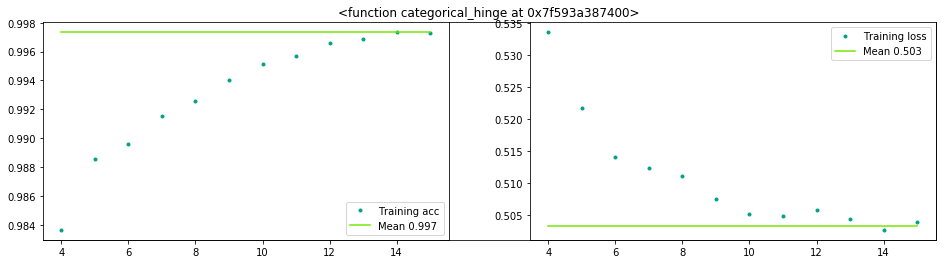

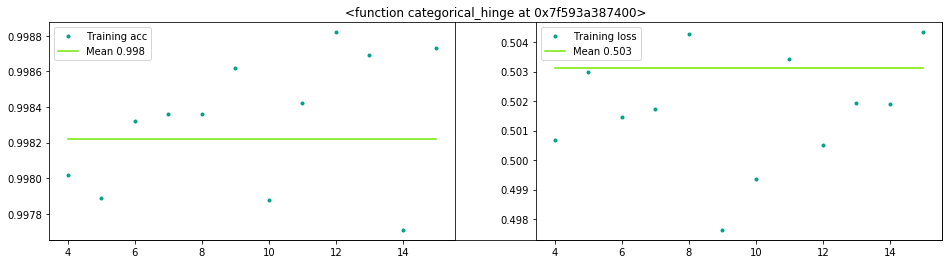

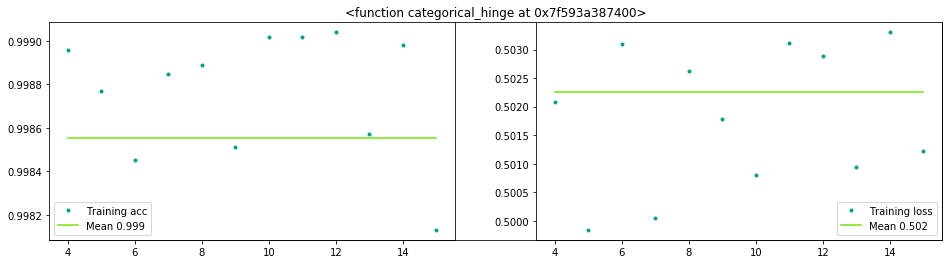

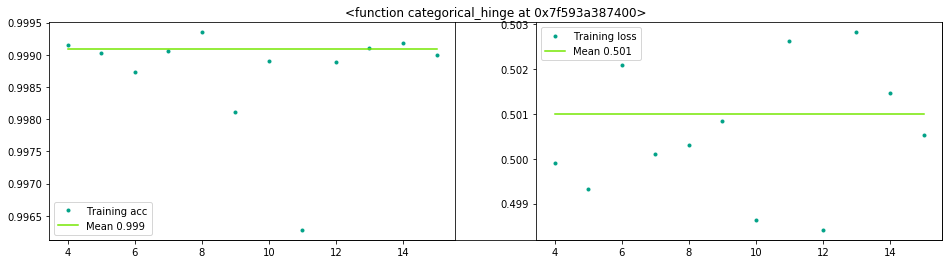

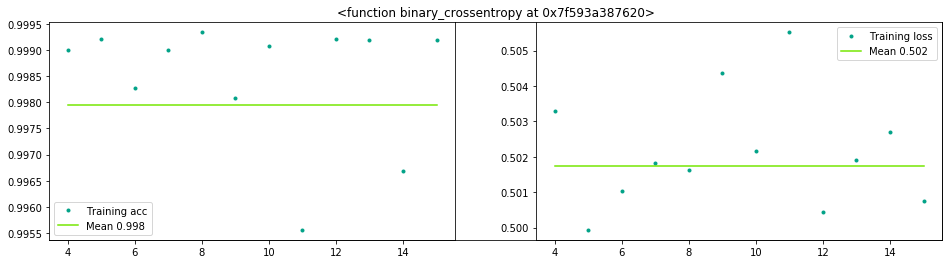

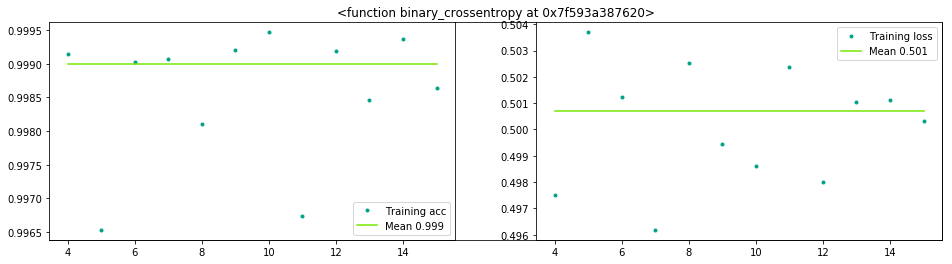

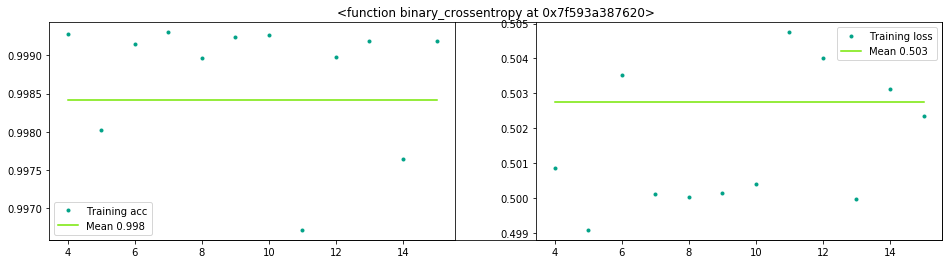

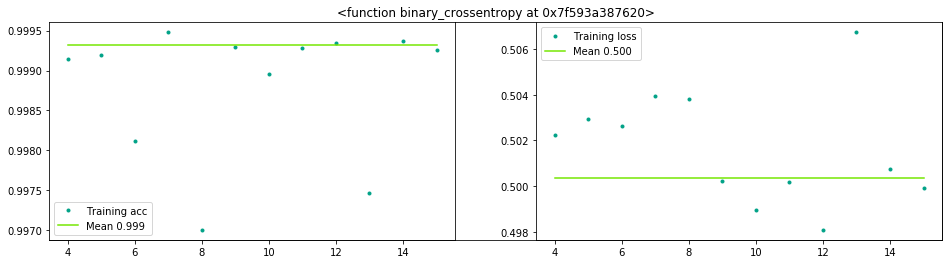

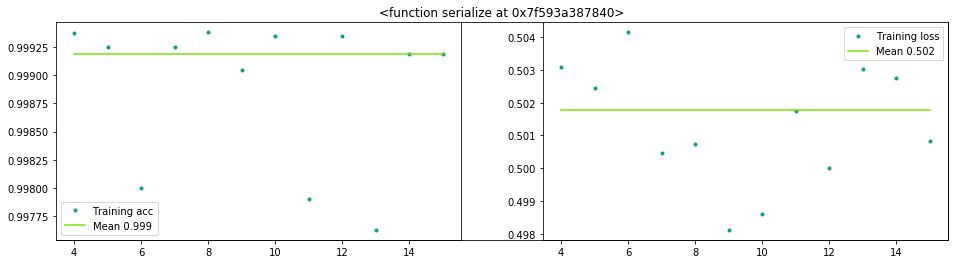

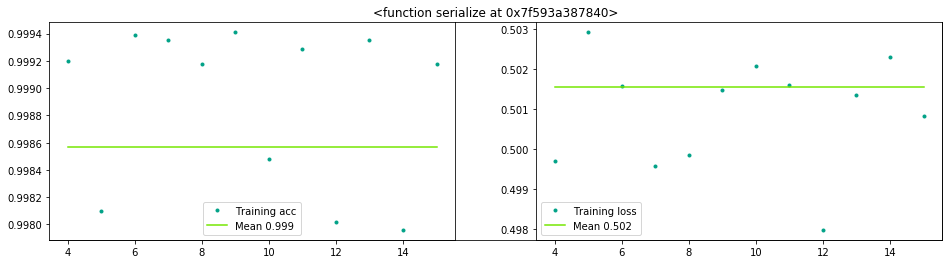

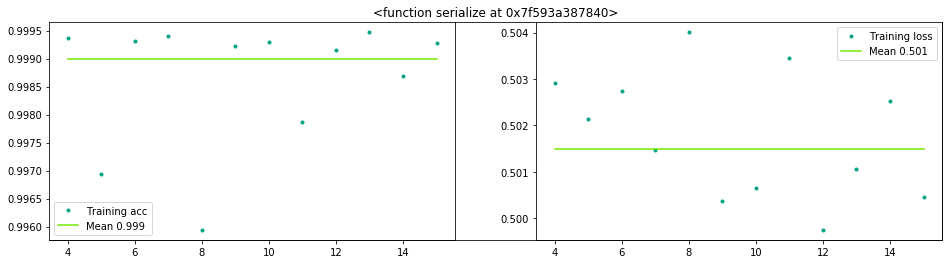

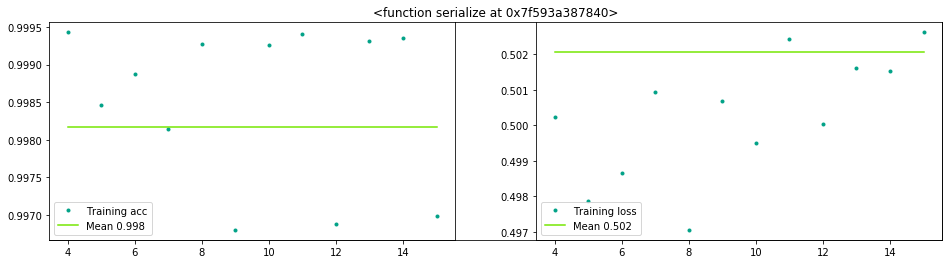

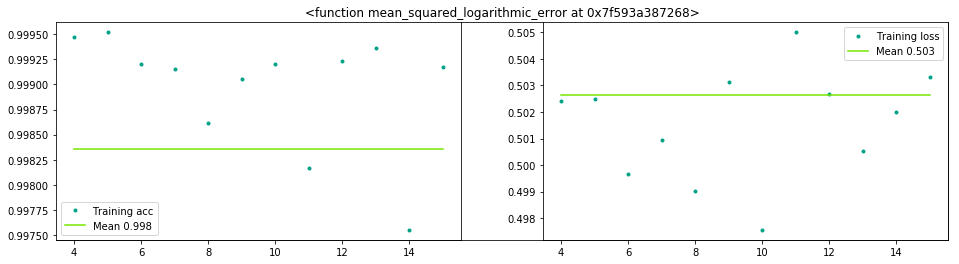

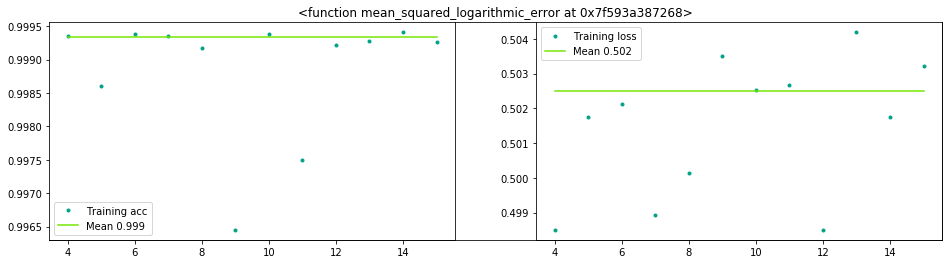

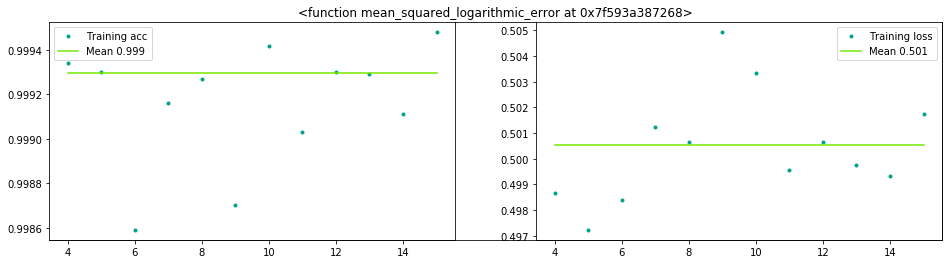

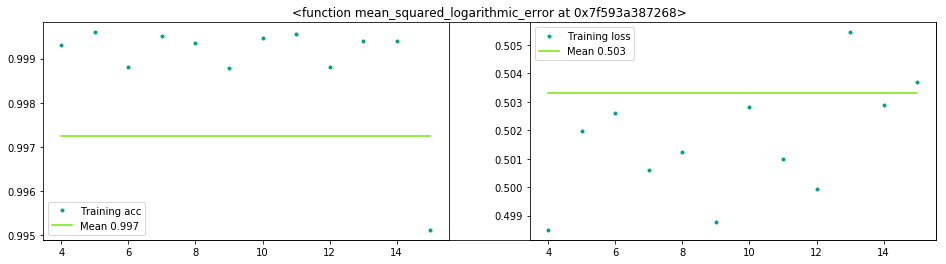

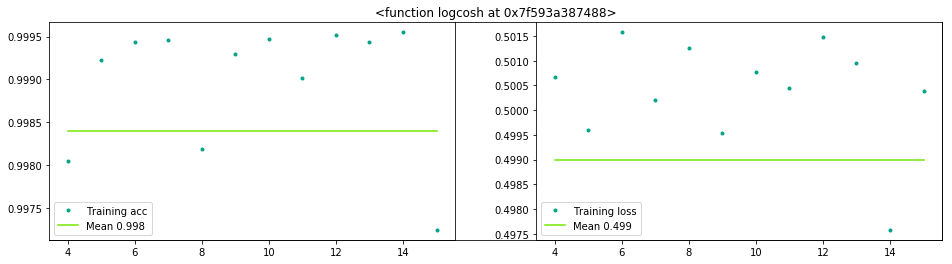

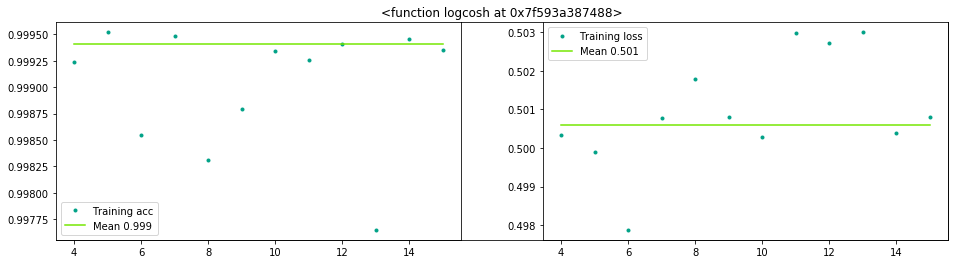

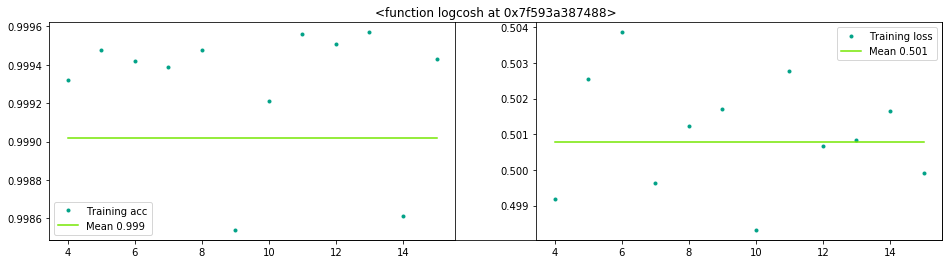

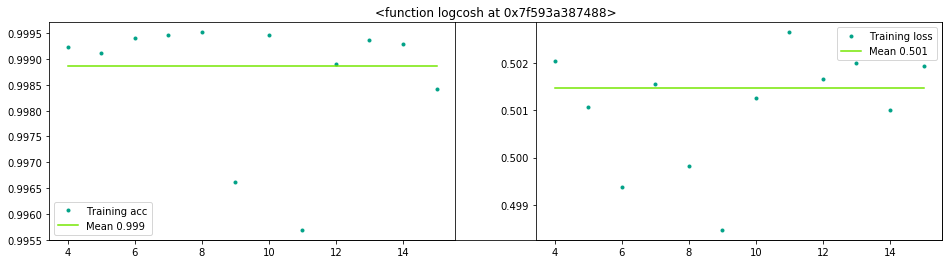

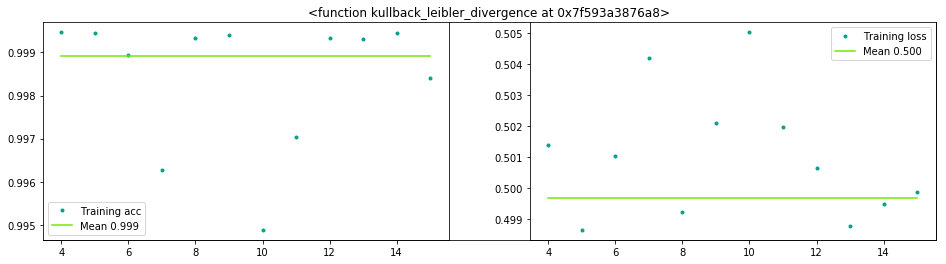

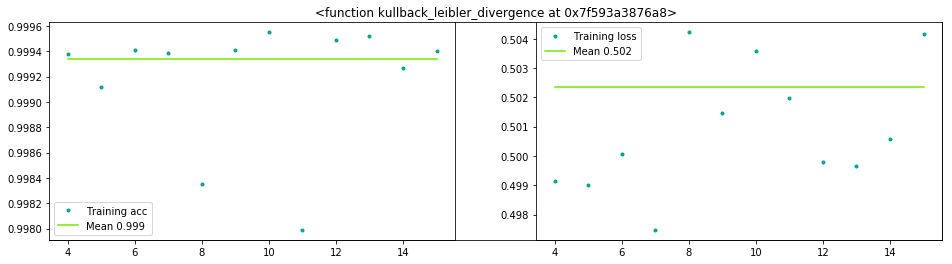

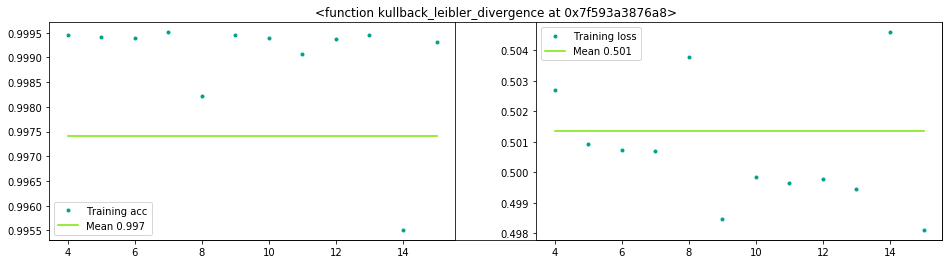

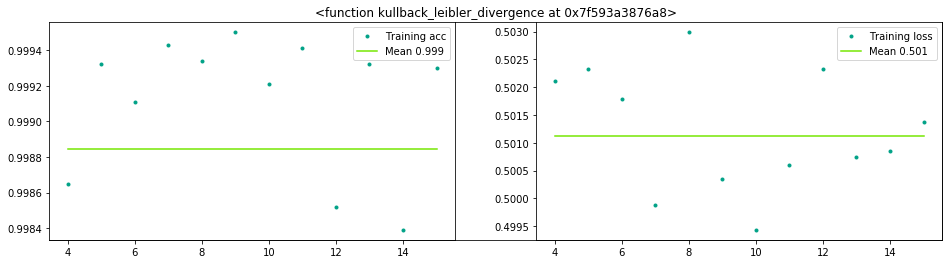

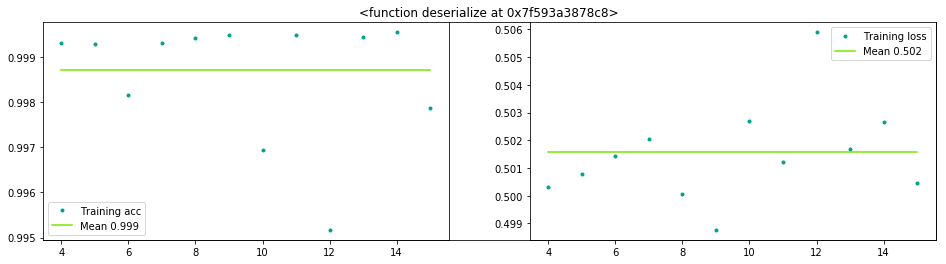

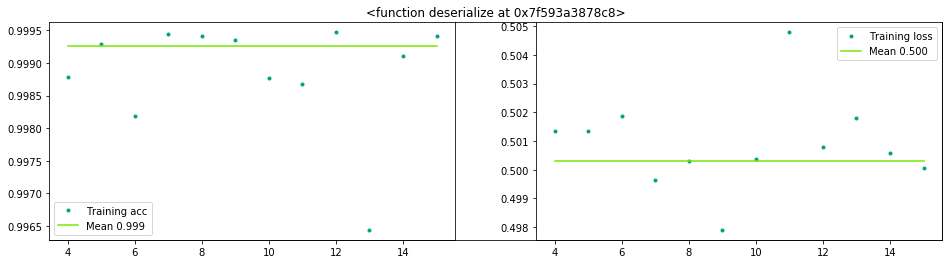

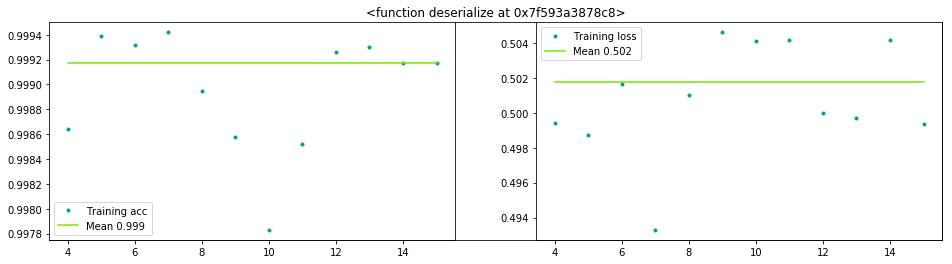

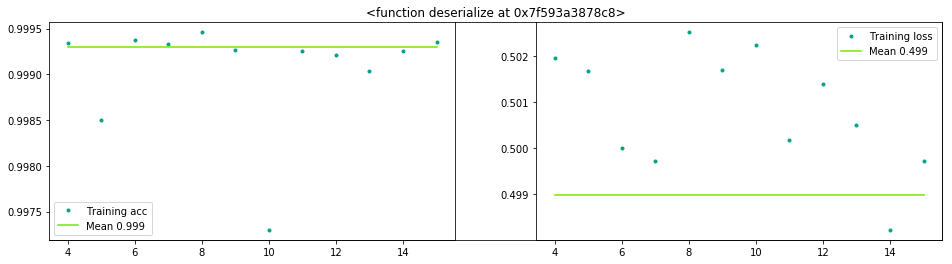

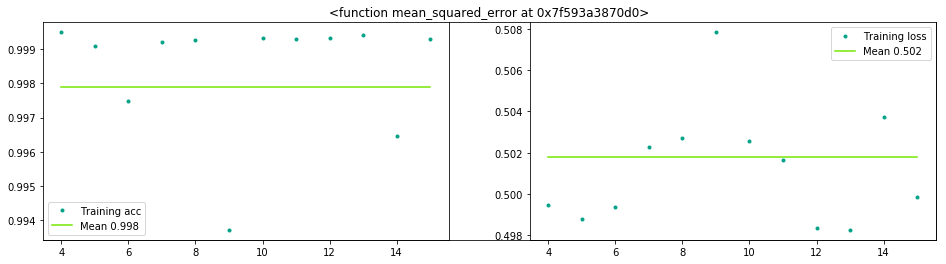

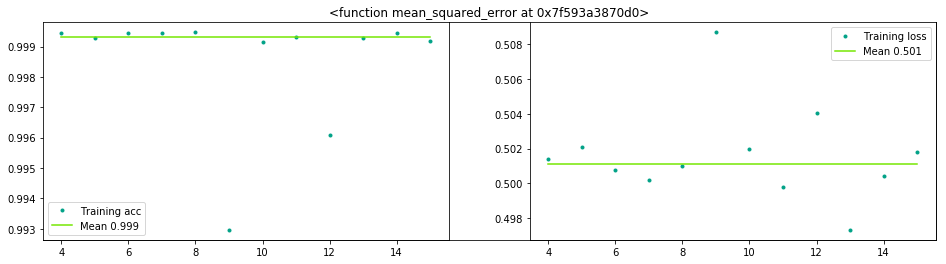

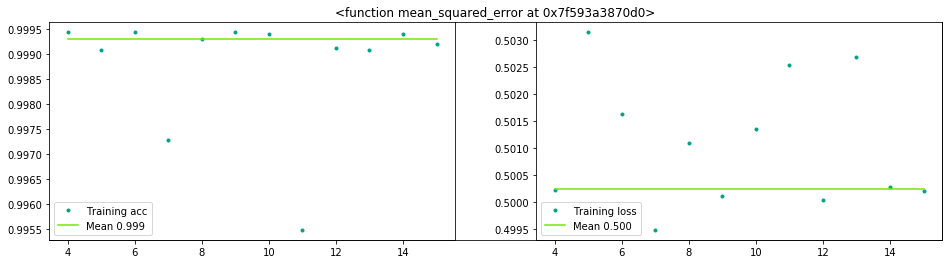

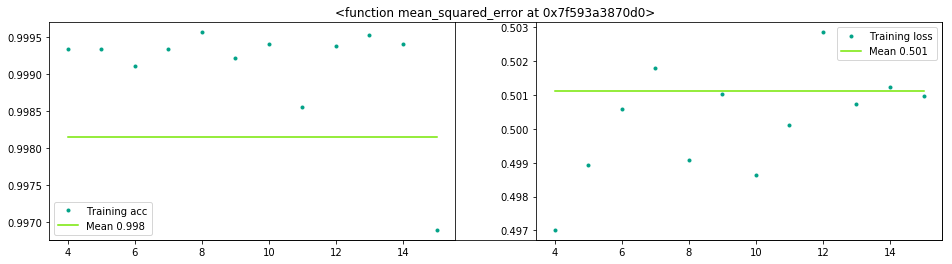

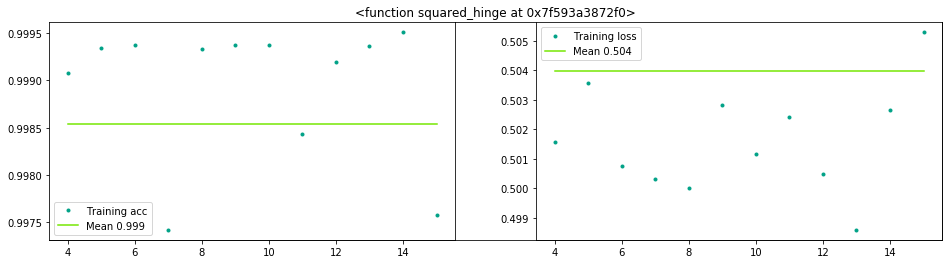

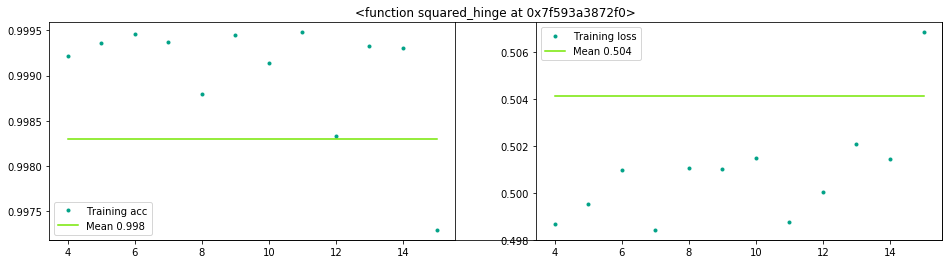

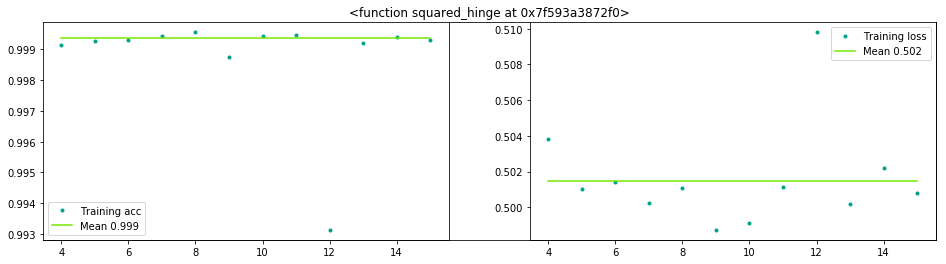

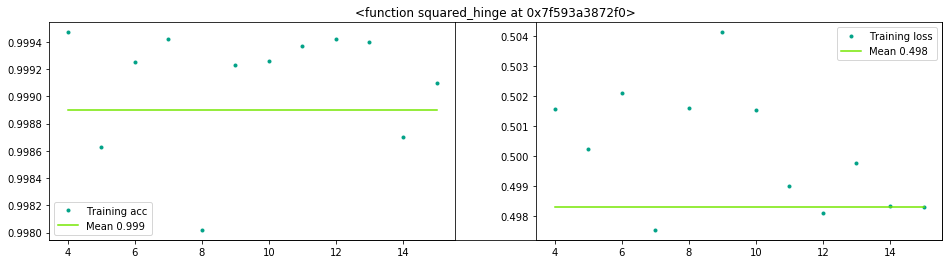

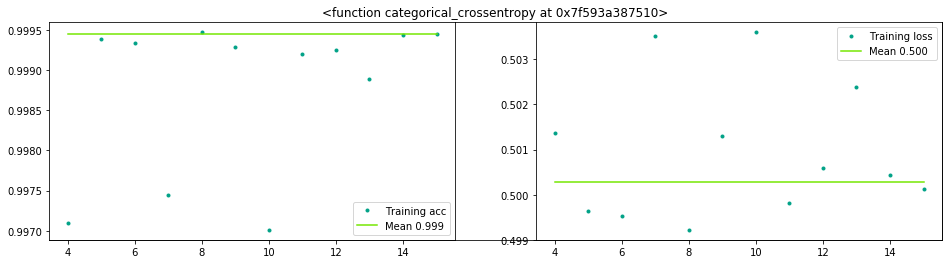

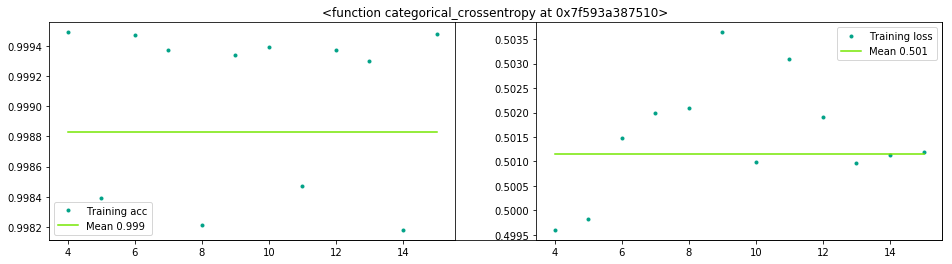

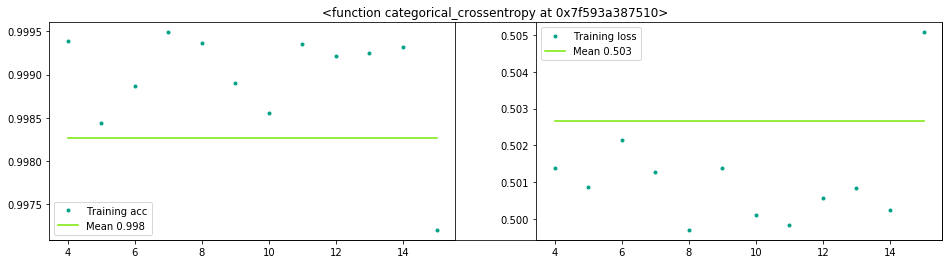

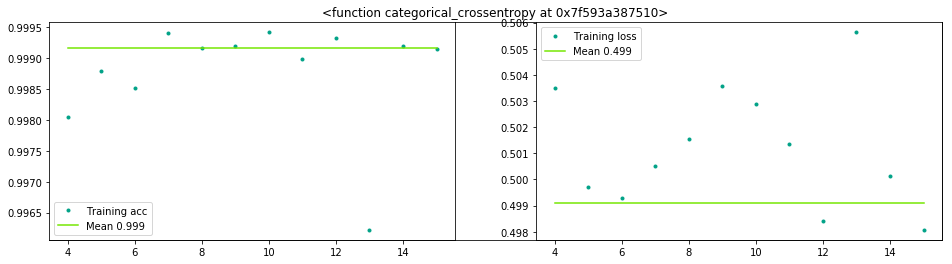

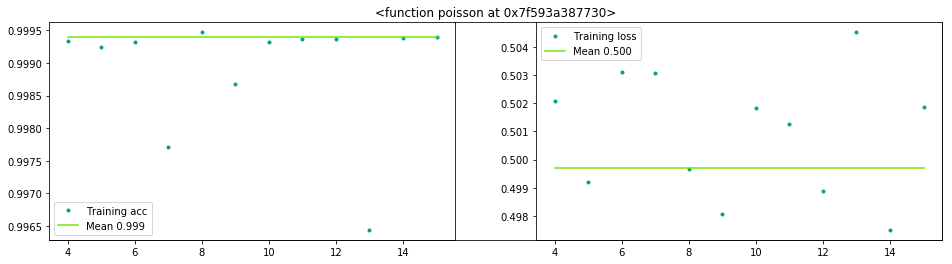

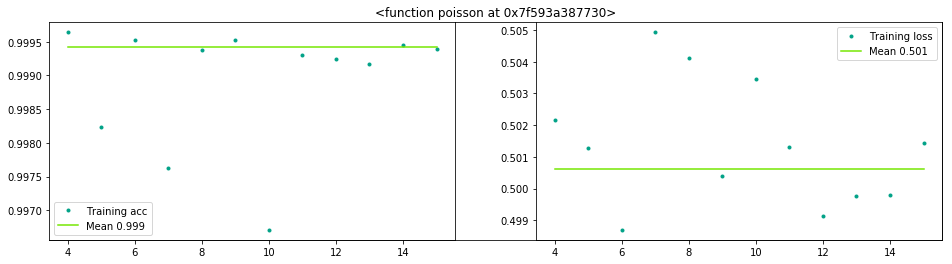

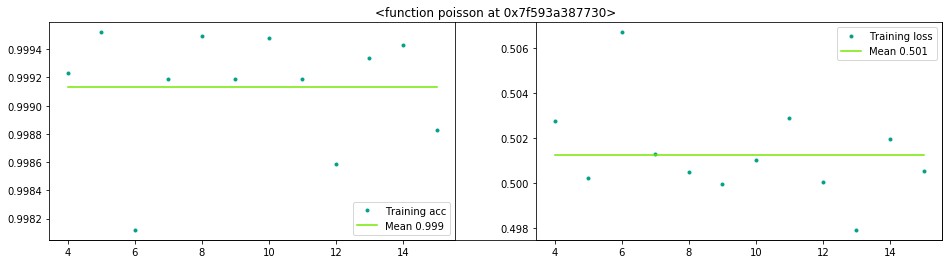

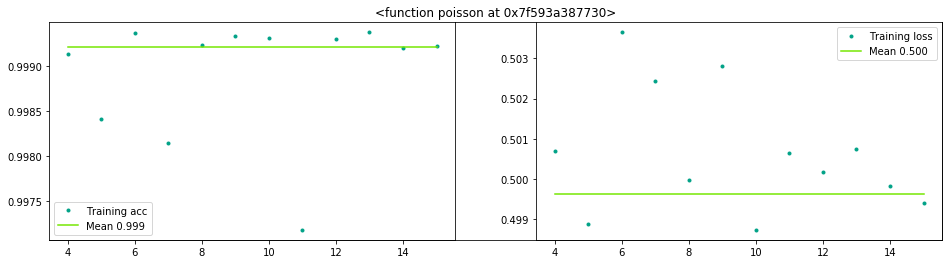

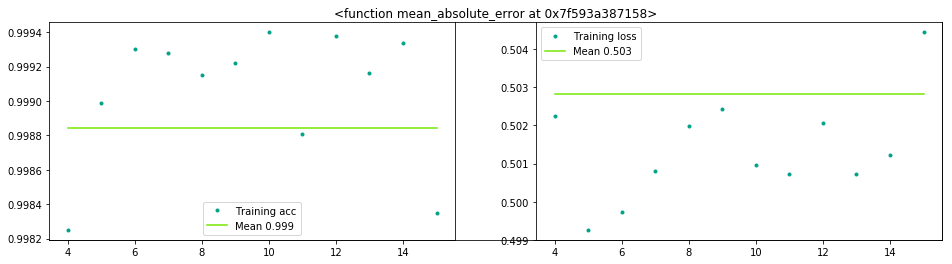

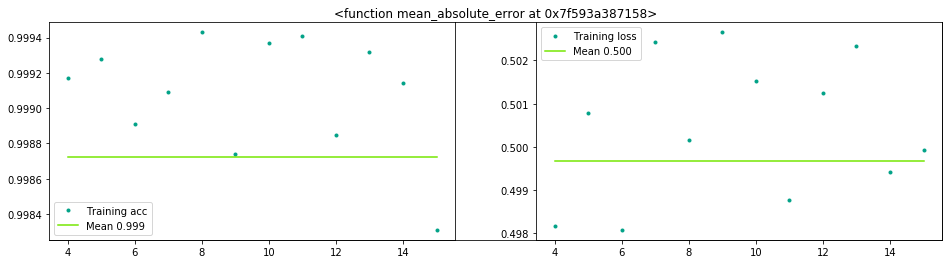

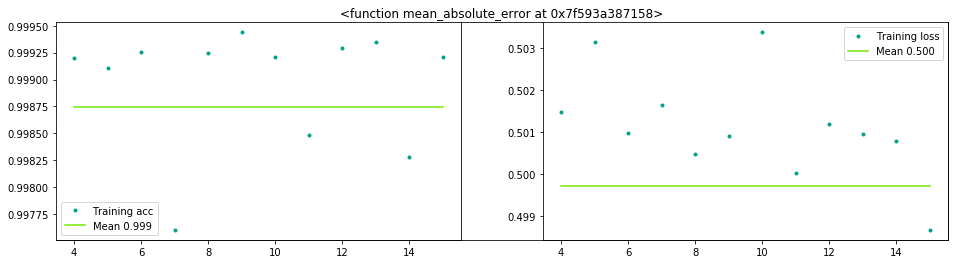

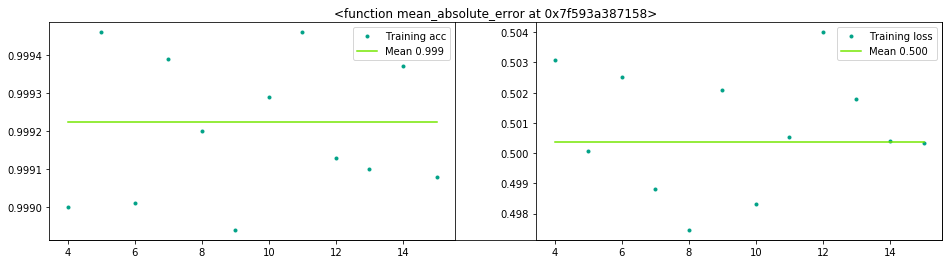

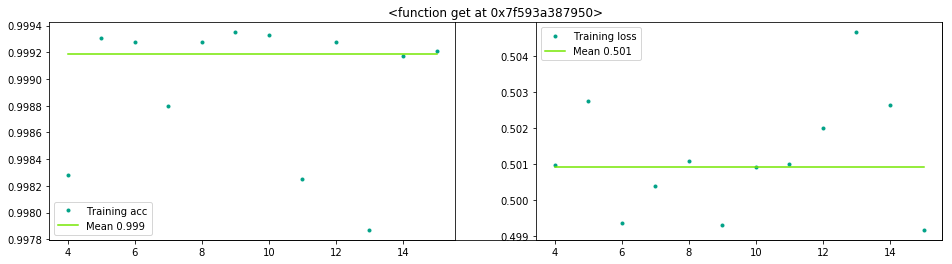

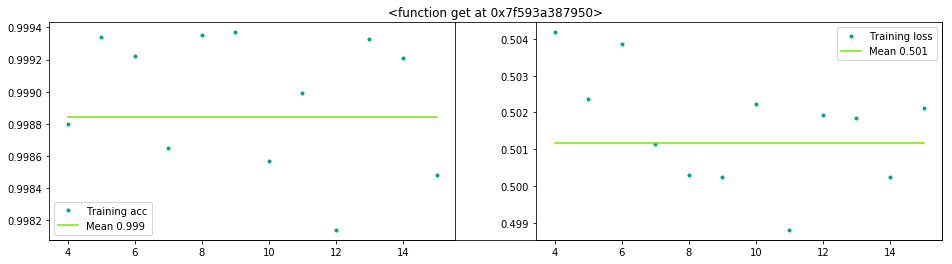

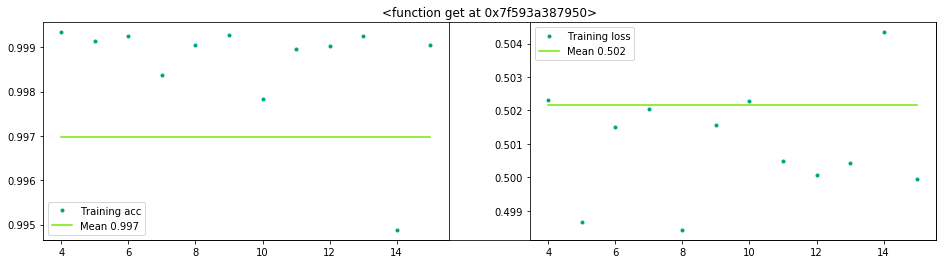

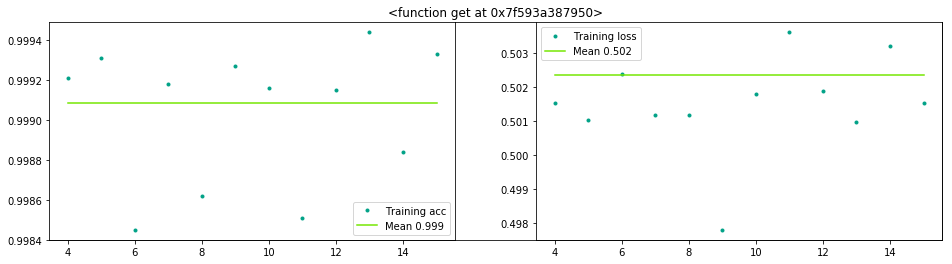

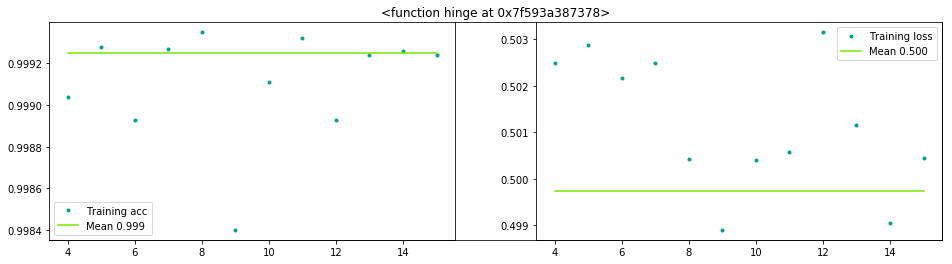

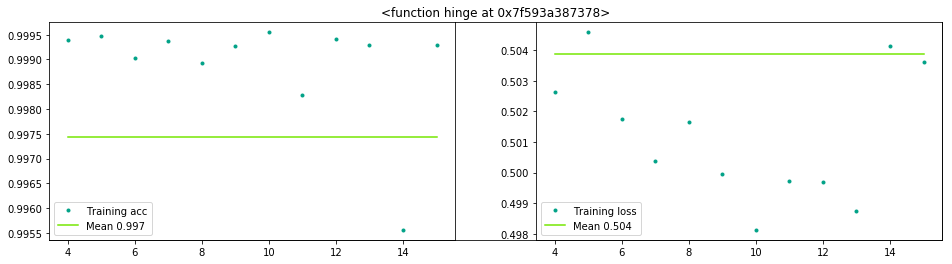

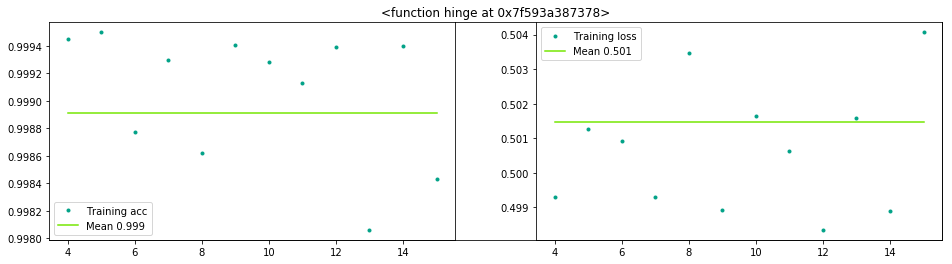

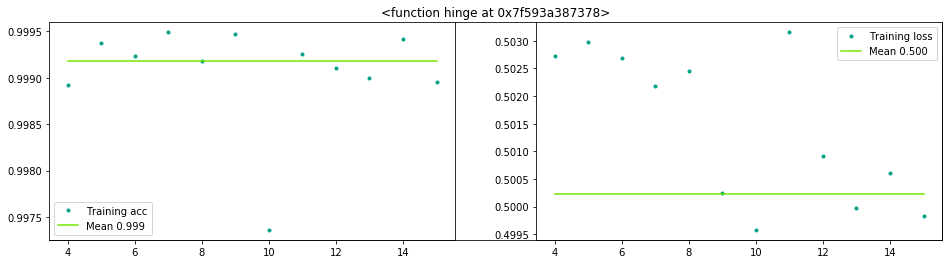

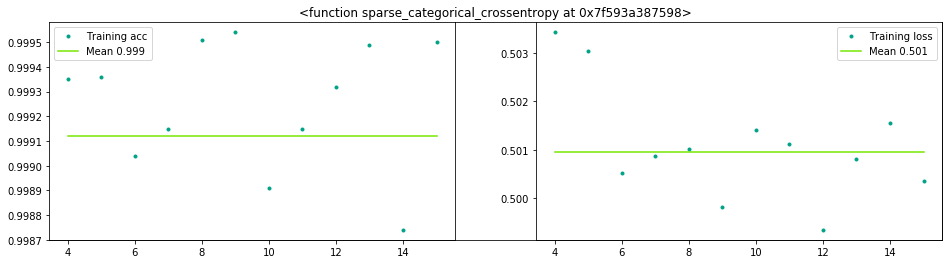

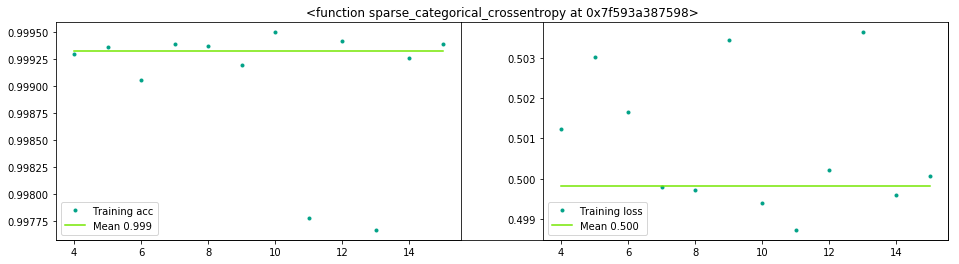

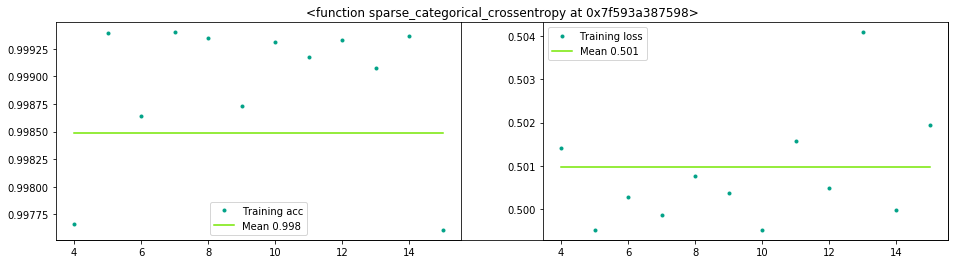

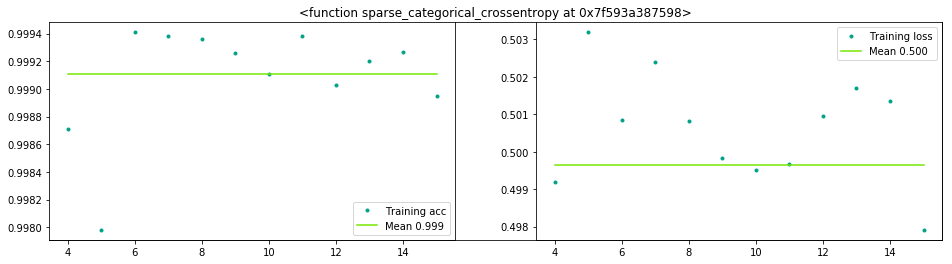

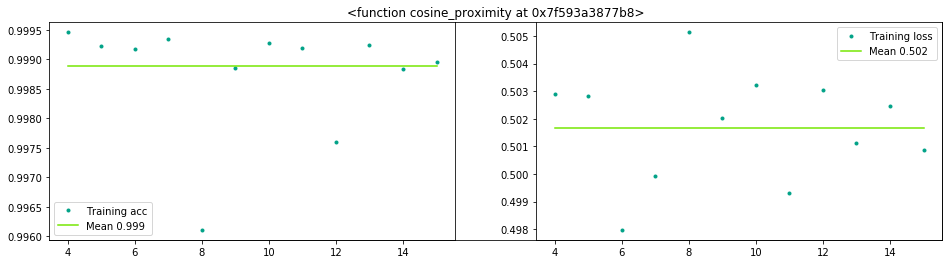

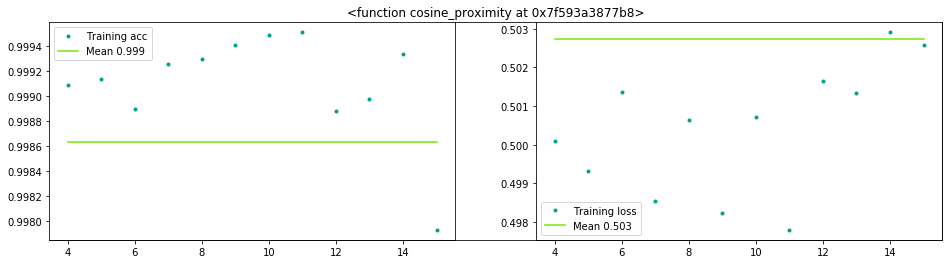

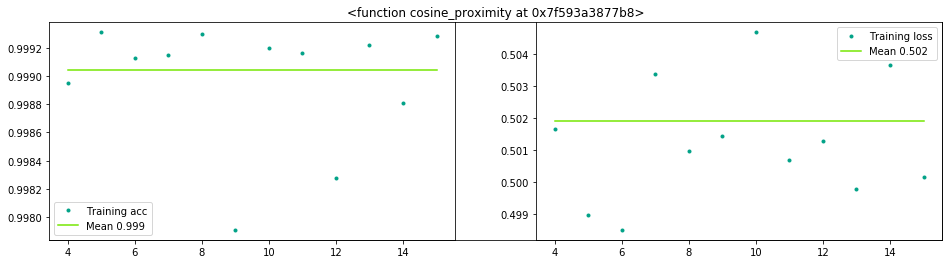

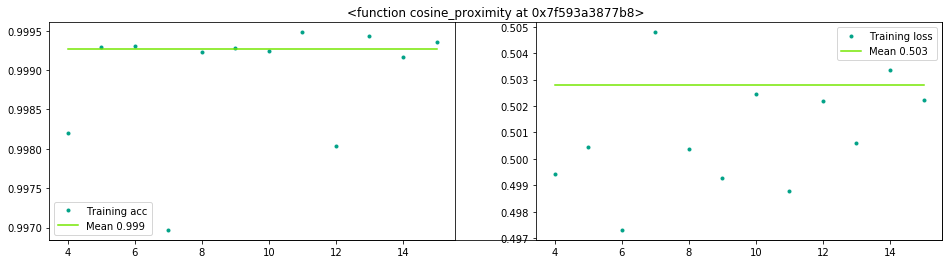

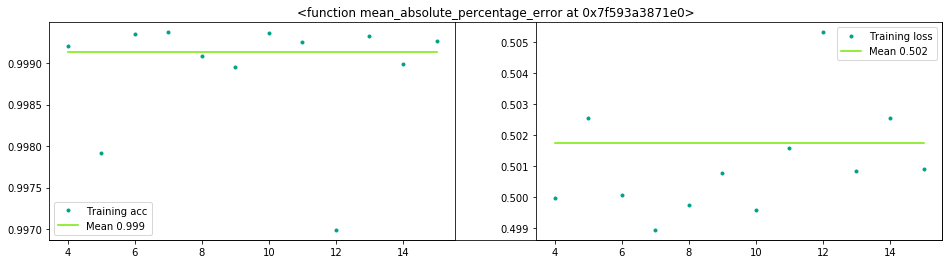

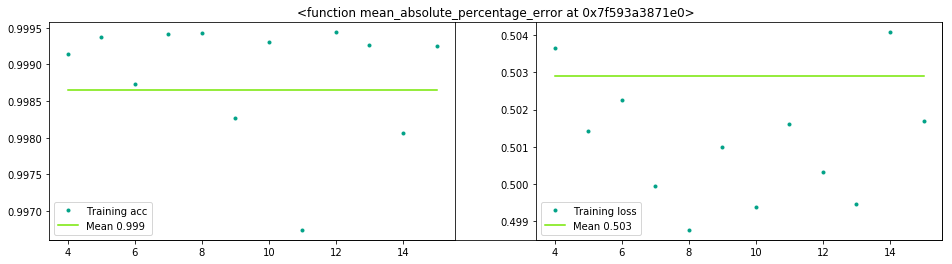

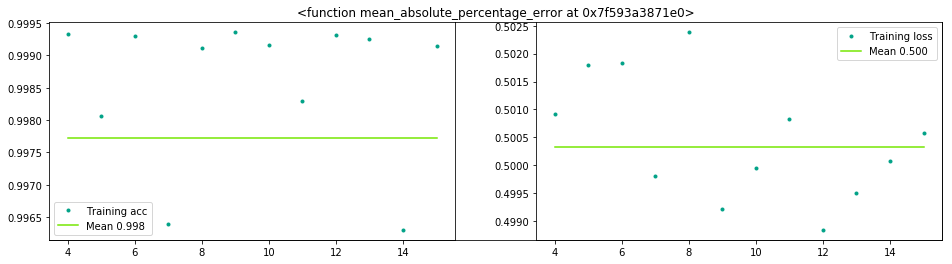

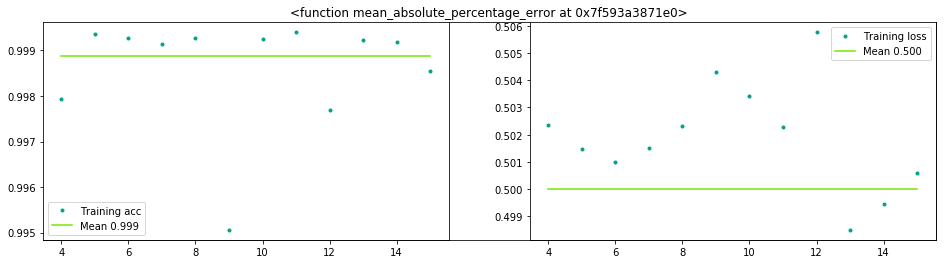

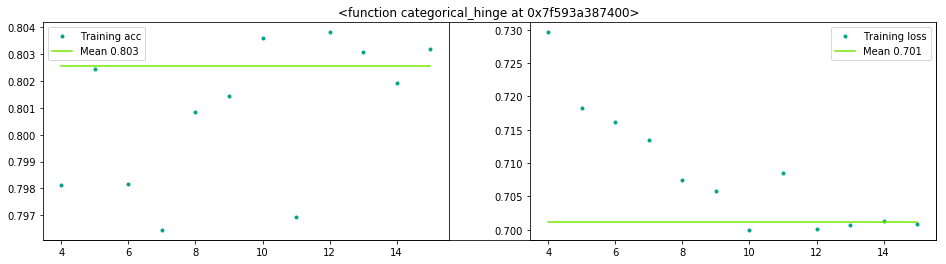

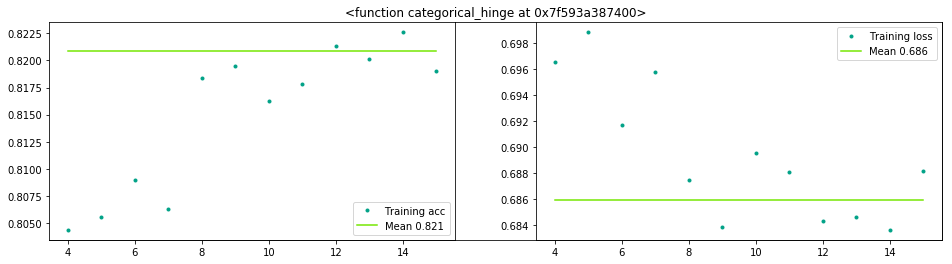

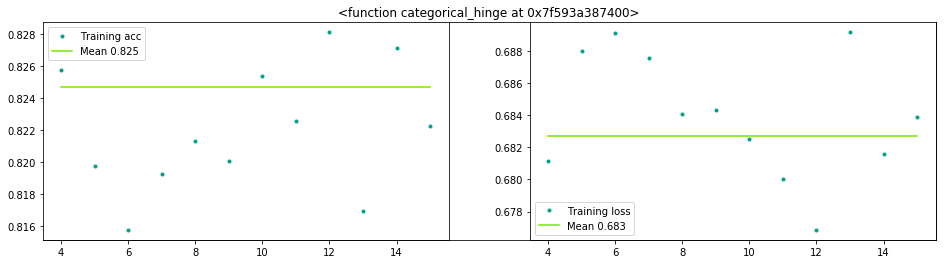

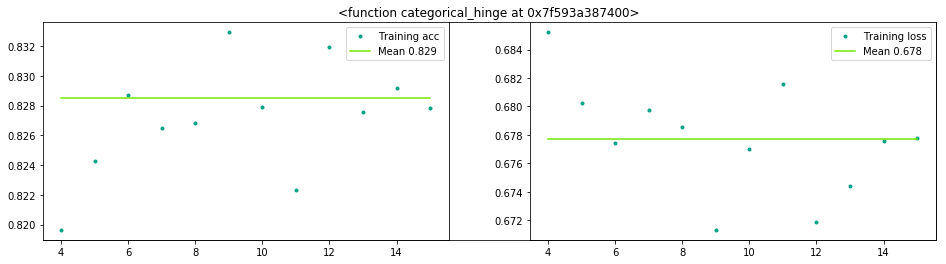

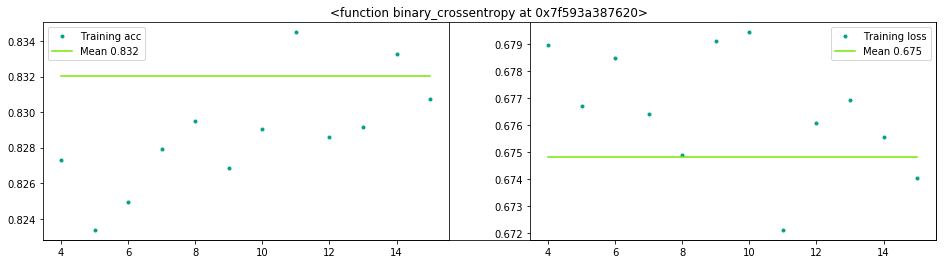

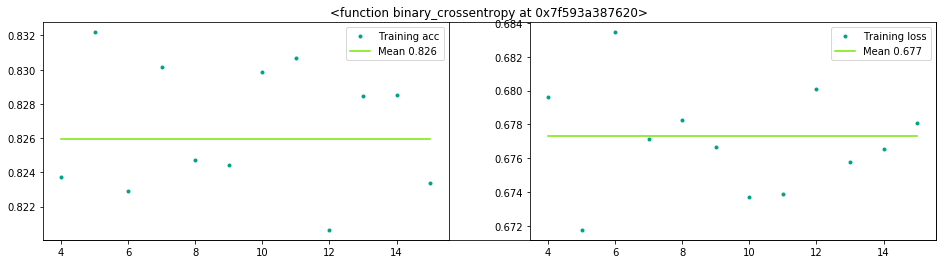

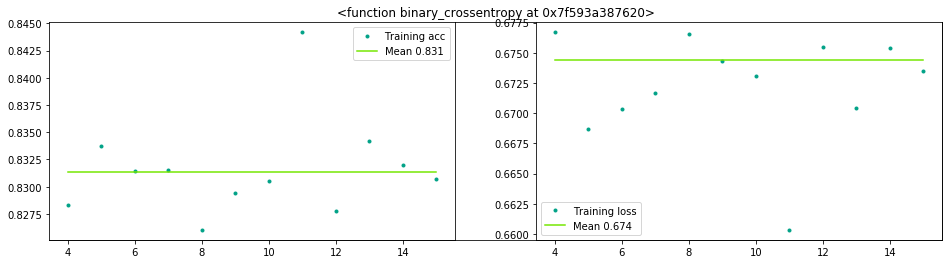

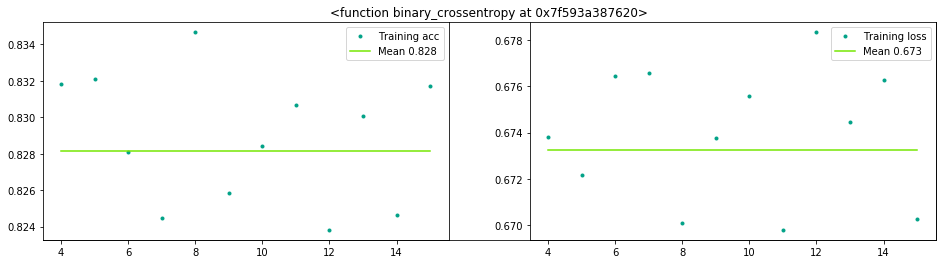

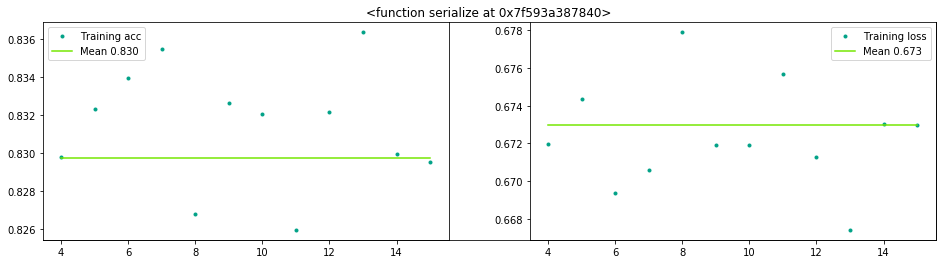

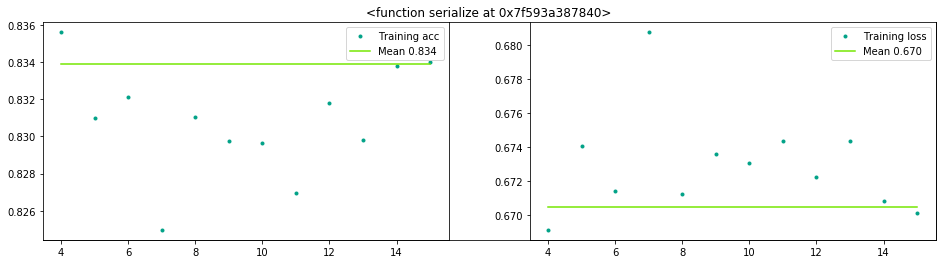

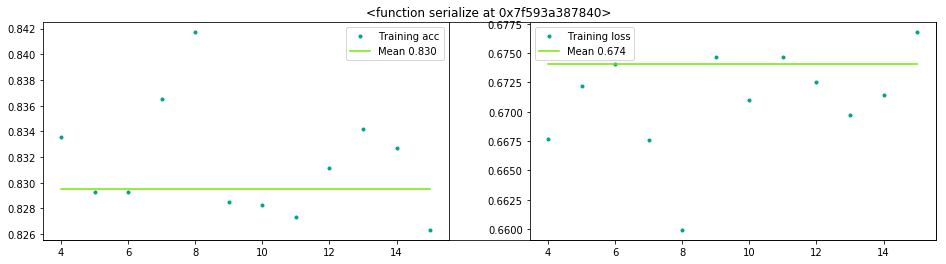

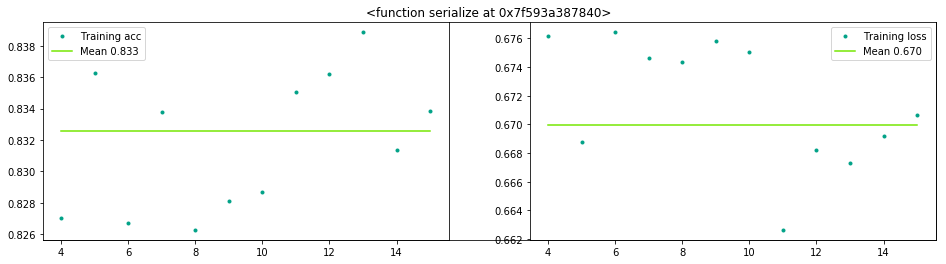

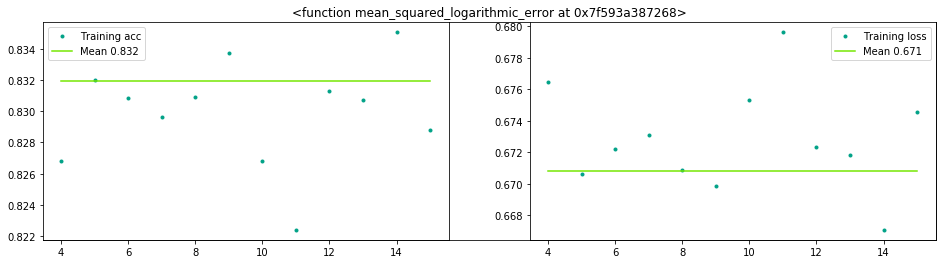

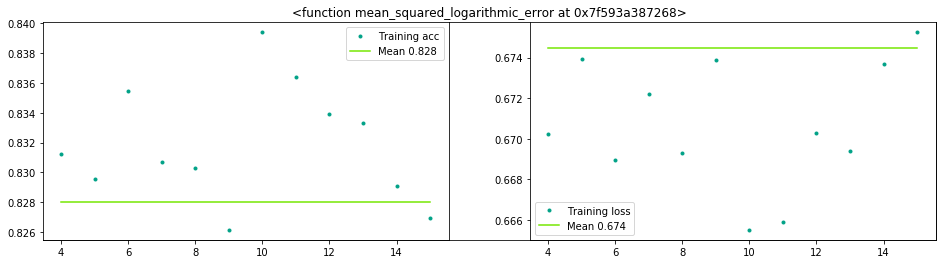

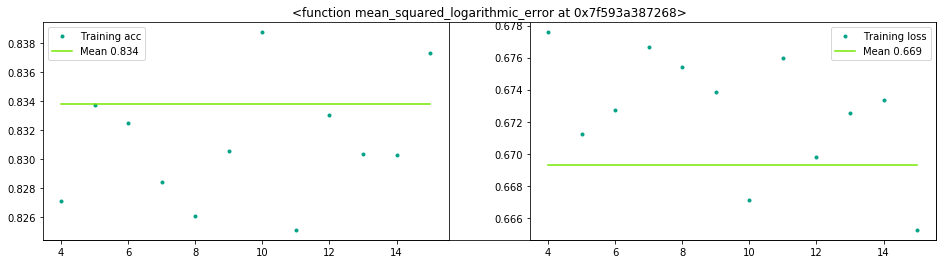

maximum recursion depth exceeded in comparison


























































































































In [11]:
gen = variable_length_data_generator(
    batch_size=100,
    sequence_lengths=(2,2,4,5,10,50),
    from_numbers=2*(np.random.sample(10000)-0.5),
    sorted_label=0,
    unsorted_label=1
)

for model_layers in models:
    for v in losses:
        if callable(v):
            for i in range(4):
                try:
                    train_and_show_hist(v, model_layers)
                except Exception as err:
                    print(err)

In [13]:
next(gen)

StopIteration: 

In [12]:
for i in range(100):
    x, y = get_sequence_label_pair(L, 10*np.random.sample(100)-5)
    
    y = -1*y + 1
    
    #print(np.max(np.concatenate(((-x[1:] + x[:-1]), np.zeros(9))).reshape(2, 9), axis=0))
    
    print(x, y, model.predict(x.reshape(1, 10, 1)).flatten()[0])

NameError: name 'L' is not defined